In [1]:
import pandas as pd
import numpy as np
from nltk.corpus import sentiwordnet as swn
import re
import os
import nltk
import langdetect
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
""" Get Data """ 

reload = False

#check if data already exists 
if not os.path.isfile('taglines.pickle') or reload:

    filePath = '/Users/arimorcos/Databases/imdb/taglines.list'

    # create pandas data frame 
    df = pd.DataFrame(columns=['title','year','tagline'])


    f = open(filePath,'r')
    skipInd = False
    for line in f:
        if line[0] == '#': # if the beginning of a new entry 
            try:
                # search for title 
                filmTitle = re.search('(?<=\# \").*(?=\" \()', line).group(0).encode('utf8')

                # get date 
                filmYear = int(re.search('(?<=\" \()\d{4}',line).group(0))
            except (AttributeError, UnicodeDecodeError):
                skipInd = True

            #initialize tagline
            filmTag = ''
        elif line != '\n': # if string is not empty 
            try:
                filmTag = filmTag + line.encode("utf8")
            except UnicodeDecodeError:
                skipInd = True
        else: 
            if not skipInd:
                
                #check language and skip if not english
                lang = langdetect.detect(filmTag)
                if lang != 'en':
                    continue
                
                # remove html tags 
                filmTag = BeautifulSoup(filmTag).get_text()
                
                # store data 
                dfInd = df.shape[0]
                df.loc[dfInd] = [filmTitle, filmYear, filmTag]
            else:
                skipInd = False

    df.to_pickle('taglines.pickle')
else:
    df = pd.read_pickle('taglines.pickle')

In [116]:
""" Get genres """ 
genreReload = True

#check if data already exists 
if not os.path.isfile('genres.pickle') or genreReload:
    
    filePath = '/Users/arimorcos/Databases/imdb/genres.list'

    # create pandas data frame 
    genreDF = pd.DataFrame(columns=['title','year','genre'])
    
    f = open(filePath,'r')
    for line in f:
        if line[0] == '"': # if the beginning of a new entry 
            try:
                # search for title 
                filmTitle = re.search('(?<=\").*(?=\")', line).group(0).encode('utf8')

                # get date 
                filmYear = int(re.search('(?<=\" \()\d{4}',line).group(0))
                
                # get genre
                filmGenre = re.search('(?<=\s)[a-z,A-Z,-]+$',line).group(0)
                
                # store data 
                dfInd = genreDF.shape[0]
                genreDF.loc[dfInd] = [filmTitle, filmYear, filmGenre]
            except (AttributeError, UnicodeDecodeError):
                continue



    genreDF.to_pickle('genres.pickle')
else:
    genreDF = pd.read_pickle('genres.pickle')

In [129]:
genreDF = genreDF.drop_duplicates(subset=['title','year'])
genreDF.to_pickle('genres.pickle')

In [127]:
df = df.merge(genreDF,on='title',how='left')

In [75]:
def synSetMatch(synSet,POS):
    
    #get part of speech in synSet
    m = re.search('(?<=\.)[a-z](?=\.\d\d)',synSet.unicode_repr())
    testPOS = m.group(0)

    #determine if a match 
    if testPOS == 'n' and POS in ['NN']:
        return True
    elif testPOS == 'v' and POS in ['VBG','VBZ','VBP','MD']:
        return True 
    elif testPOS == 'a' and POS in ['JJ','JJS']:
        return True
    elif testPOS == 'r' and POS in ['RB']:
        return True 
    else:
        return False
    

In [128]:
""" Save """
df.to_pickle('taglines.pickle')

In [92]:
""" Get score for each tagline """

# add score column 
if not any(df.columns == 'score'):
    df.insert(len(df.columns),'score',None)

# loop through each row and get score 
for index in range(df.shape[0]):
#for index in range(5):
    
    # get word list 
    wordList = nltk.wordpunct_tokenize(df.loc[index,'tagline'])
    
    # add pos tags
    wordList = nltk.pos_tag(wordList)
    keepPOS = ['VBG','NN','VBZ','JJ','JJS','RB','MD','VBP']
    
    # get score
    totalScore = 0.0
    for word in wordList:
        if word[1] in keepPOS:
            try:
                wordSet = swn.senti_synsets(word[0])
                
                #filter non-matching value 
                wordSet = [testWord for testWord in wordSet if synSetMatch(testWord, word[1])]
                
                posScore = np.nanmean([word.pos_score() for word in wordSet])
                negScore = np.nanmean([word.neg_score() for word in wordSet])
                netScore = posScore - negScore
                if np.isnan(netScore):
                    continue
            except IndexError:
                continue
        else: 
            continue

        totalScore += netScore
    
    # store score 
    df.loc[index,'score'] = totalScore
    

In [95]:
""" Calculate mean score for each year """ 
maxYear = int(max(df.loc[:,'year']))
minYear = int(min(df.loc[:,'year']))
minYear = 1960

yearList = range(minYear, maxYear)
avgScore = []
for year in yearList:
    avgScore.append(np.mean(df[df.year == year]['score']))

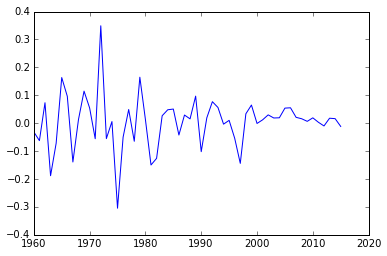

In [101]:
smoothScore = pd.Series(avgScore);
smoothScore = pd.rolling_mean(smoothScore,2)
plt.plot(yearList,avgScore);

In [94]:
df

,title,year,tagline,score
0,#ATown,2014,ATown is a female driven comedy about friendsh...,0.3846154
1,#AwkwardMornings,2014,"Sometimes, the morning after a fun night out c...",-0.078125
2,#Hashtag: The Series,2013,Friend Me. Follow Me. Like Me. Fall for Me.\n,0.075
3,#LawstinWoods,2013,You haven't been this lost since 'Lost' until ...,-0.01785714
4,#PrettyPeopleProblems,2013,"Pretty on the outside, ugly-crying on the insi...",-0.2857143
5,#SayWhat?!,2013,We say what you're thinking about pop culture....,0.2508897
6,#ScenesFromRussia,2013,Times for the gay community in Russia have gon...,-0.5328947
7,$25 Million Dollar Hoax,2004,Her family thinks she won the lottery...What a...,0.04166667
8,"$5,000 Video",2013,Jash gave a comedian five thousand dollars to ...,-0.1041667
9,'Til Death,2006,"Take a picture, it'll last longer.\n",-0.0375
